### Tutorial 2: Clustering on embryo slices

In this tutorial, we will show how to use the stCAMBL model to perform spatial transcriptomic analysis of mouse emvryo slices. Relevant data can be obtained from github.

**Import the relevant python analysis package**

In [8]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import stCAMBL
import os
#Please change this path to your local R environment path
os.environ['R_HOME'] = '/data3/wkcui/env/anaconda3/envs/stCAMBL/lib/R'

**Read data and perform data preprocessing**

In [5]:
dataset = 'Mouse_Embryo'
random_seed = 2050
stCAMBL.set_seed(random_seed)
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
# read data
# Please change this path to your local data path
file_path = '/data3/yfchen/stCAMBL/data/E9.5_E1S1.MOSTA.h5ad' 
n_clusters = 14
adata = sc.read_h5ad(file_path)
adata.var_names_make_unique()
# preprocess data
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=3000)

adata = adata[:, adata.var['highly_variable'] == True]

sc.pp.scale(adata)


**Perform stCAMBL analysis**

In [6]:
from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

graph_dict = stCAMBL.graph_construction(adata, 12)
model = stCAMBL.stCAMBL(adata.obsm['X_pca'], graph_dict, device=device)
# Begin to train the model
dataset = 'Mouse_Embryo'
model.train_model(epochs=400, dataset=dataset)
stCAMBL_feat, defeat, _, _, _ = model.process()
adata.obsm['emb'] = stCAMBL_feat

100%|██████████| 400/400 [01:27<00:00,  4.58it/s]


**clustering**

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


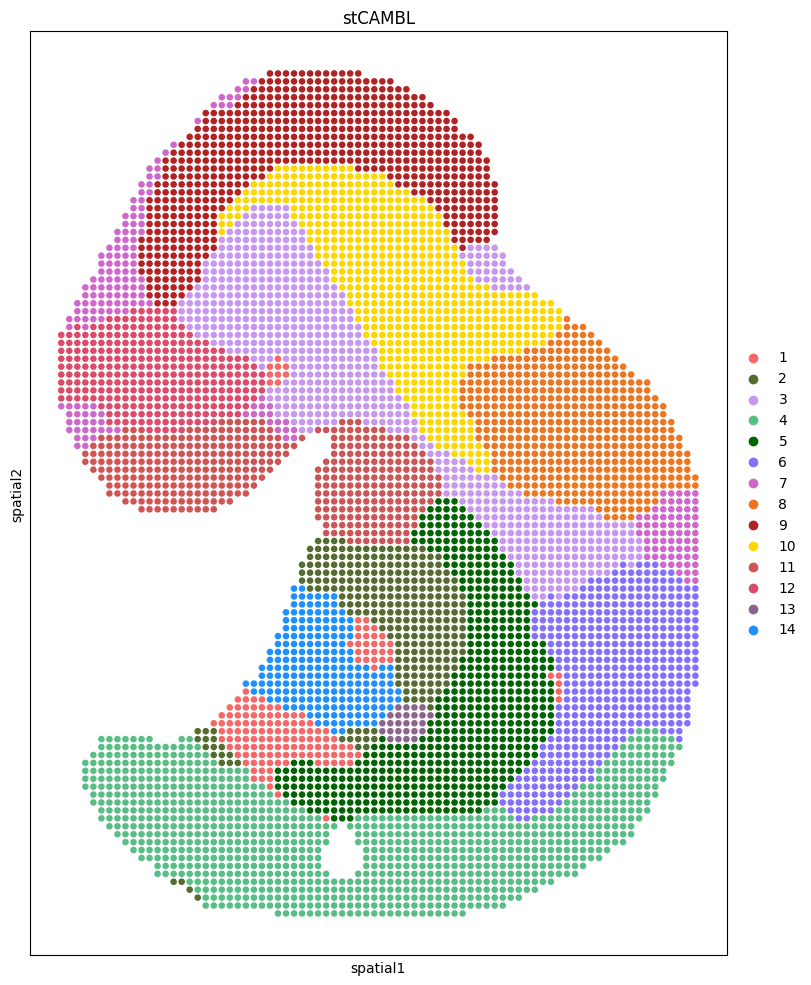

In [9]:
radius = 50
tool = 'mclust' 
# clustering
from stCAMBL.clust_func import clustering
clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)

adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (9, 12)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
           "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
          "#877F6C","#268785", '#82EF2D', '#B4EEB4']


ax = sc.pl.embedding(adata, basis="spatial",
                    color='domain',
                    s=90,
                    show=True,
                    palette=plot_color,
                    title='stCAMBL')

